In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import json
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import functools
from tqdm import tqdm

from tasks.clock.vis import visualize_latent, visualize_predictions, visualize_reconstruction, print_model_parameters, show_data, get_outputs, map_inputs
from tasks.clock.utils import eval_model, load_model_and_dataset

from models.decoders import ImplicitNeuralDecoder, ResNetDecoder3, ResNetDecoder4
from models.autoencoders import MLPResnetAutoencoder, ConvINRAutoencoder
from models.encoders import ConvMLPEncoder

sys.path.append(os.path.join(os.getcwd(), '..'))
device = "cuda" if torch.cuda.is_available() else "cpu"

model_dir="saved_models/MLPResnetAutoencoder/-2-i64-d22-aug"

load_model_checkpoint = functools.partial(
  load_model_and_dataset, 
  model_class=MLPResnetAutoencoder,
  model_dir=model_dir,
)

cp = load_model_checkpoint(checkpoint=0)

ModuleNotFoundError: No module named 'clock'

: 

In [5]:
print_model_parameters(load_model_checkpoint(checkpoint=0).model)

Layer                                       Param Count
------------------------------------------------------------
------------------------------------------------------------
Total Trainable Parameters                    8,080,323


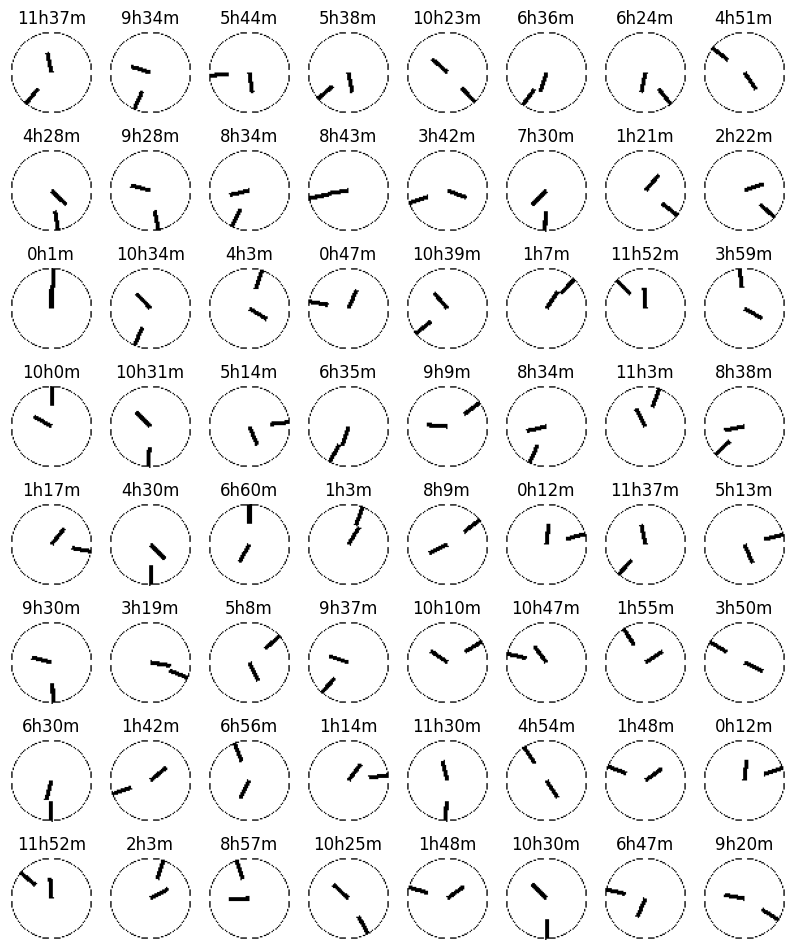

In [7]:
for i in range(1):
  show_data(cp.val_dataloader.dataset)

In [9]:
cp = load_model_checkpoint()
eval_model(model=cp.model, type_=cp.type, latent_dim=cp.latent_dim, loss_fn=nn.SmoothL1Loss(), val_data=[i for i in cp.val_dataloader], device=device)

0.005572643436607905

# Encoders

In [10]:
visualize_predictions(cp)

Not encoder


# Decoders

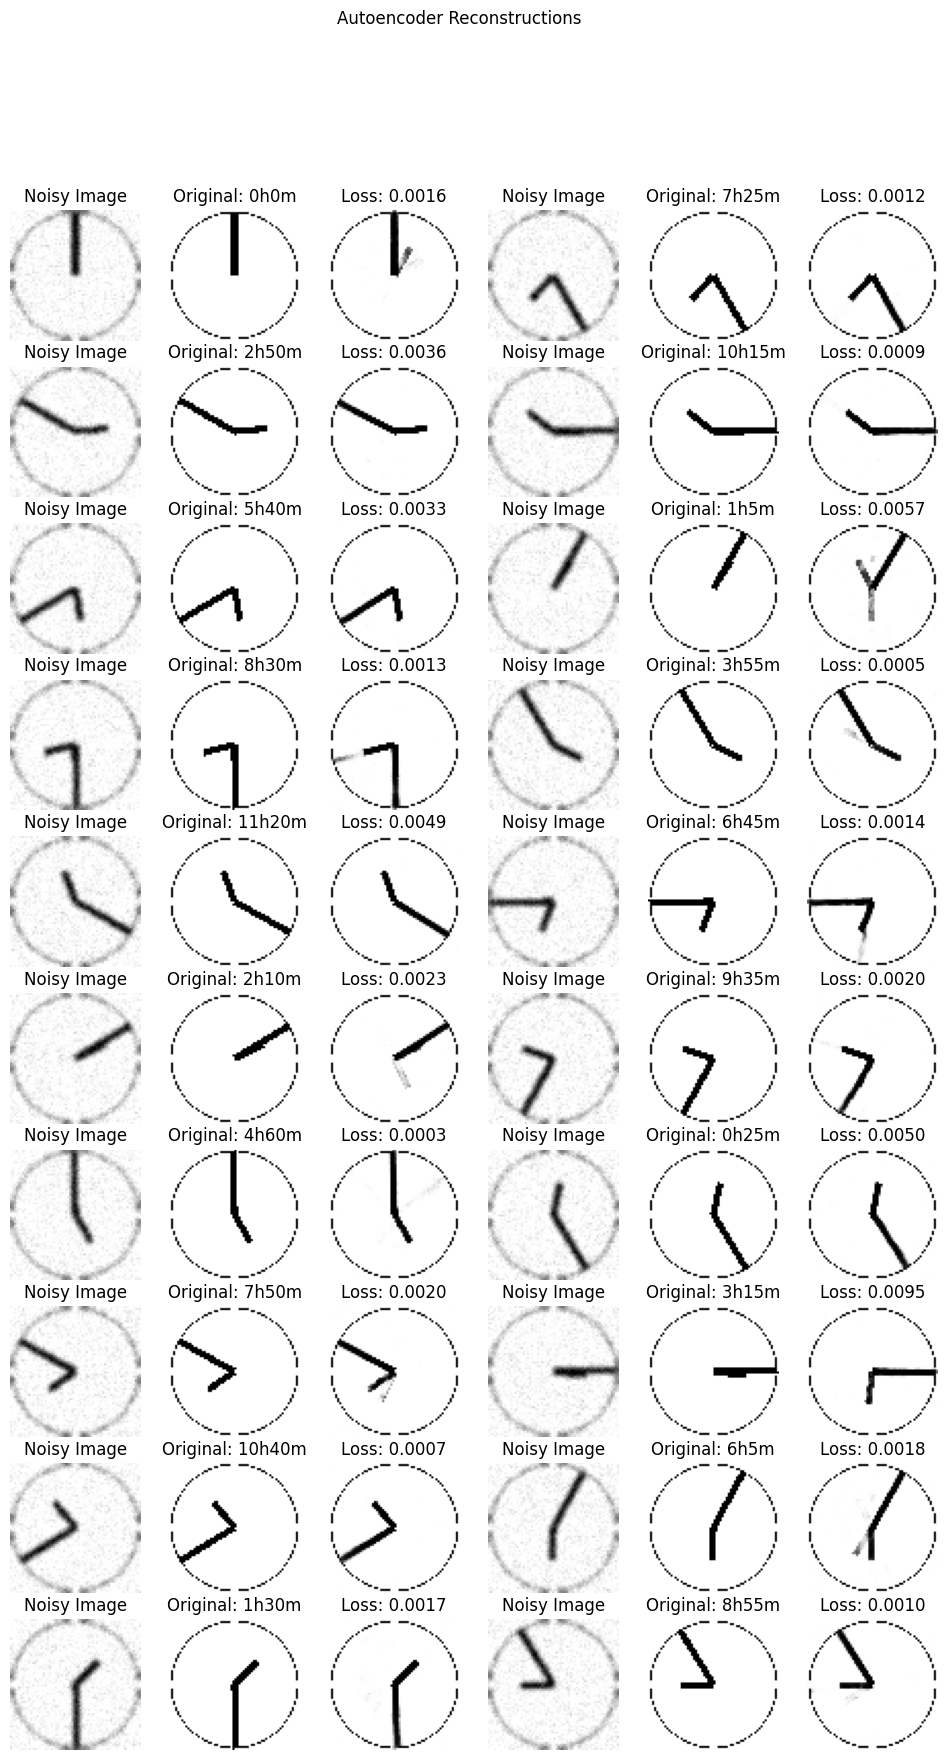

In [3]:
visualize_reconstruction(load_model_checkpoint())

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

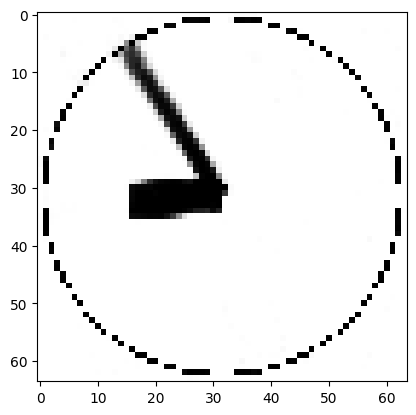

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

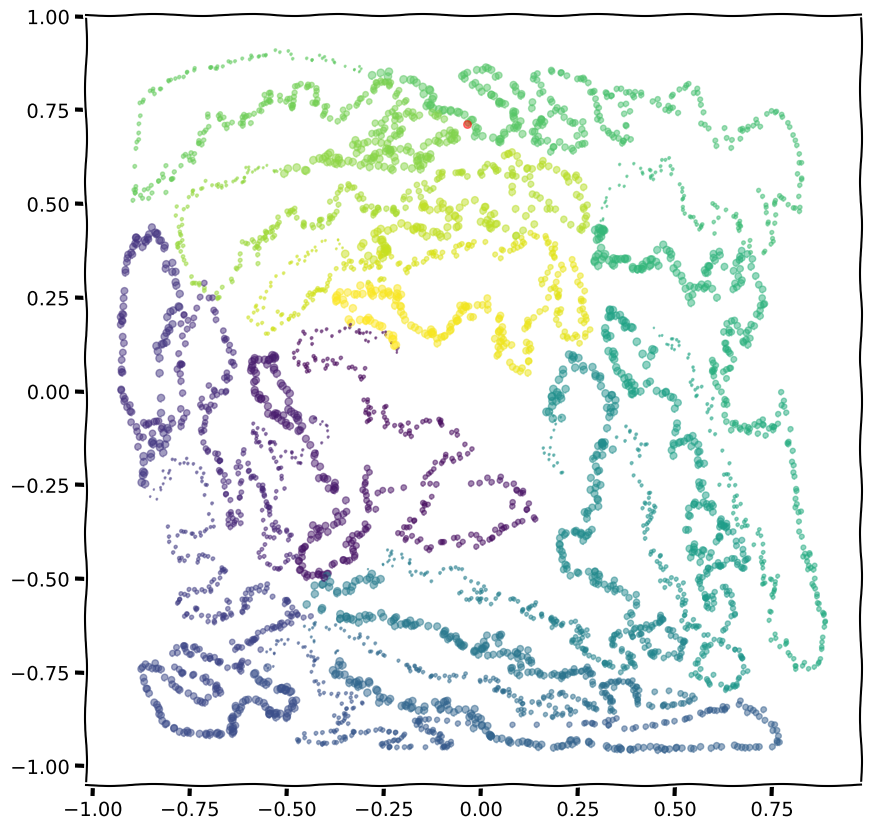

In [2]:
cp = load_model_checkpoint(checkpoint=10)
idx = 19
img, _, selected_label2d, label1d = cp.dataloader.dataset[idx]
with torch.no_grad():
  selected_latent = cp.model.encoder(img.unsqueeze(0).to(device)).cpu().numpy()[0]
  plt.imshow(cp.model(img.unsqueeze(0).to(device)).squeeze().detach().cpu().numpy(), cmap='gray')

with plt.xkcd():

  latents_list = []
  labels1d_list = []
  labels2d_list = []
  for _, _, labels1d, labels2d, latent in map_inputs(cp, cp.model.encoder, limit=4096):
    latents_list.append(latent.unsqueeze(0).cpu())
    labels1d_list.append(labels1d.unsqueeze(0).cpu())
    labels2d_list.append(labels2d.unsqueeze(0).cpu())
    
  latents = torch.cat(latents_list, dim=0)
  labels1d = torch.cat(labels1d_list, dim=0)
  labels2d = torch.cat(labels2d_list, dim=0)

  def get_color(label2d):
    norm = plt.Normalize(label2d[:, 0].min(), label2d[:, 0].max())
    norm_lightness = plt.Normalize(label2d[:, 1].min(), label2d[:, 1].max())
    colors = plt.cm.hsv(norm(label2d[:, 0]))
    lightness = norm_lightness(label2d[:, 1])
    colors[:, :3] = colors[:, :3] * lightness[:, np.newaxis]
    return colors


  plt.figure(figsize=(10, 10))
  plt.scatter(latents[:, 0], latents[:, 1], c=labels1d, cmap='viridis', s=labels2d[:, 1]*20, alpha=0.5)


  plt.scatter(selected_latent[0], selected_latent[1], c='red', s=30, alpha=0.5)

# Autoencoders

100%|██████████| 16/16 [00:32<00:00,  2.06s/it]
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
fi

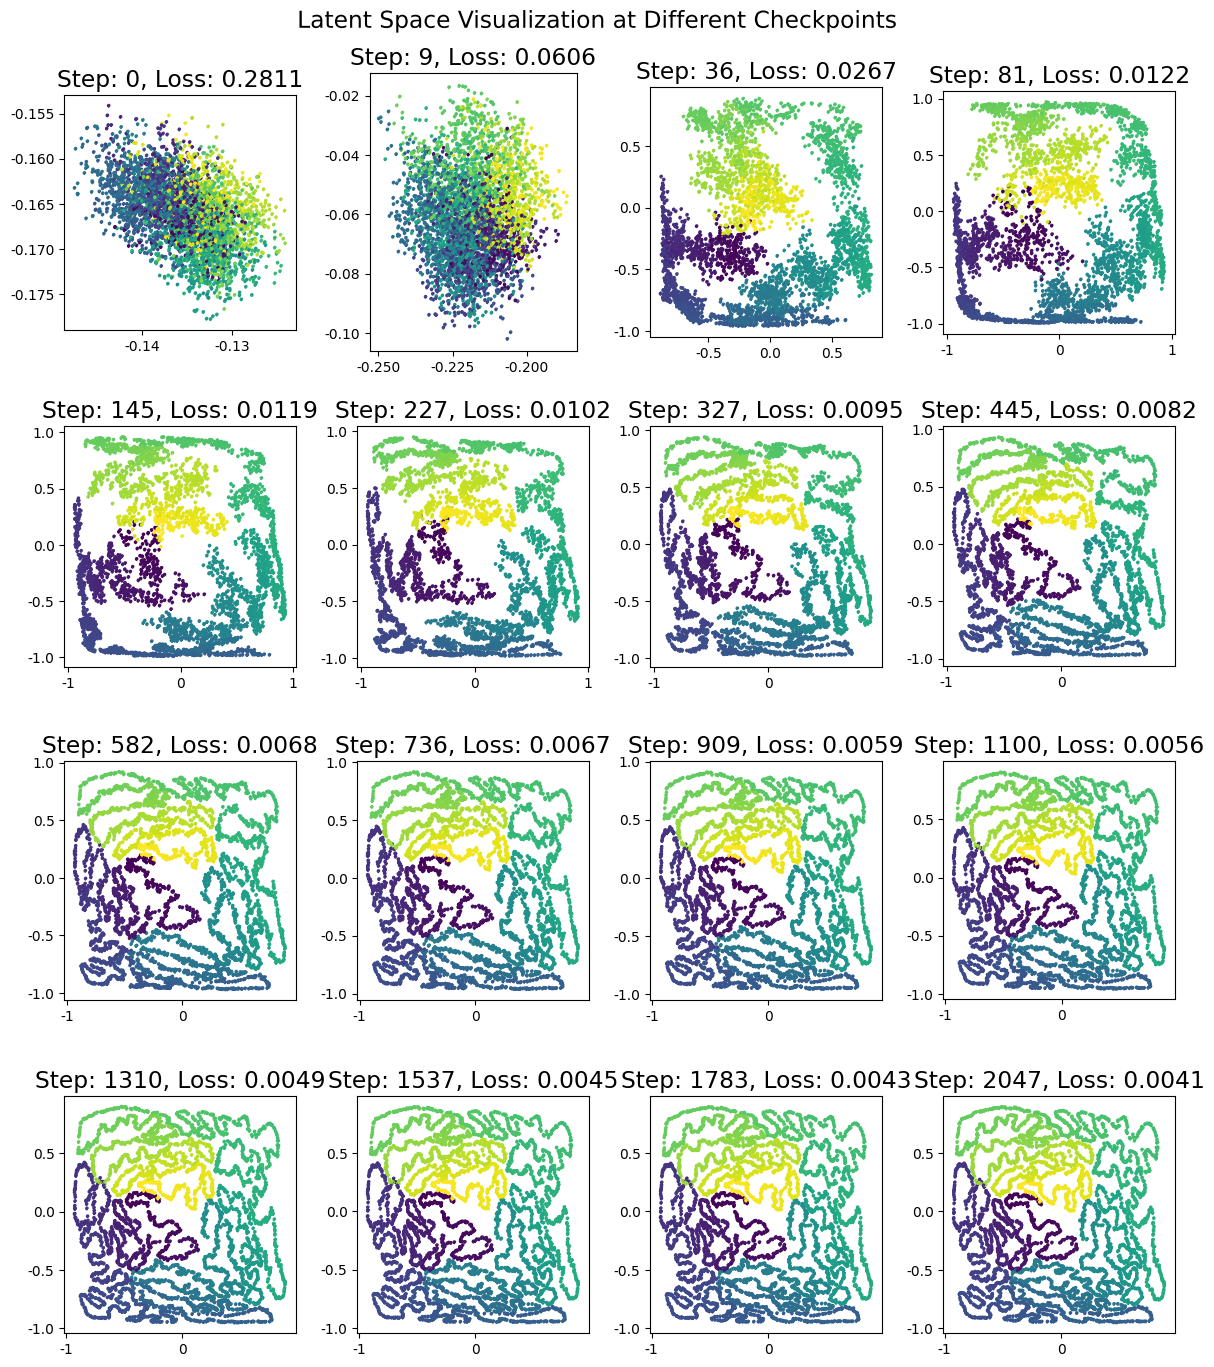

In [4]:
from sklearn.decomposition import PCA

n_checkpoints= 16
sqrt_n_checkpoints = np.ceil(np.sqrt(n_checkpoints)).astype(int)

fig, ax = plt.subplots(sqrt_n_checkpoints, sqrt_n_checkpoints, figsize=(12, 14))


def get_latent(x, model):
  return model.encoder(x)

with plt.xkcd():
  for i in tqdm(range(n_checkpoints)):
    cp = load_model_checkpoint(checkpoint=i)

    latents_list = []
    labels1d_list = []
    for _, _, labels1d, _, latent in map_inputs(cp, functools.partial(get_latent, model=cp.model), limit=4096):
      latents_list.append(latent.unsqueeze(0).cpu())
      labels1d_list.append(labels1d.unsqueeze(0).cpu())

    latents = torch.cat(latents_list, dim=0)
    labels1d = torch.cat(labels1d_list, dim=0)
    
    if cp.latent_dim > 2:
      pca = PCA(n_components=2)
      latents = pca.fit_transform(latents)
    
    ax[i//sqrt_n_checkpoints, i%sqrt_n_checkpoints].scatter(latents[:, 0], latents[:, 1], c=labels1d, cmap="viridis", s=1)
    ax[i//sqrt_n_checkpoints, i%sqrt_n_checkpoints].set_title(f"Step: {cp.step}, Loss: {cp.val_loss:.4f}")
    ax[i//sqrt_n_checkpoints, i%sqrt_n_checkpoints].set_aspect('equal', adjustable='box')
    
  plt.suptitle("Latent Space Visualization at Different Checkpoints")
  plt.subplots_adjust(top=0.9)
  plt.tight_layout()
  plt.show()


In [ ]:
import json
from clock.utils import load_model_and_dataset
from clock.vis import get_outputs
from tasks.clock.dataset import get_dataloaders
from tasks.clock.dataset import ClockConfig, ClockDatasetConfig
from models.autoencoders import MLPResnetAutoencoder
import matplotlib.pyplot as plt
import torch
import numpy as n
from tqdm import tqdm
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go


for i in tqdm(range(16)):
  cp = load_model_checkpoint(checkpoint=i)
  
  latents_list = []
  labels1d_list = []
  total_imgs = 0
  with torch.no_grad():
    for _, imgs, labels2d, labels1d in cp.dataloader:
      imgs = imgs.to(device)
      labels2d = labels2d.to(device)
      labels1d = labels1d.to(device)
      
      latent = cp.model.encoder(imgs)
      
      # Compute the latent representation
      latents_list.append(latent.cpu())
      
      labels1d_list.append(labels1d.cpu())
      total_imgs += imgs.shape[0]
      if total_imgs >= 4096:
        break
    
  latents = torch.cat(latents_list, dim=0)
  labels1d = torch.cat(labels1d_list, dim=0)
  
  if cp.latent_dim == 3:
    fig = px.scatter_3d(
      latents, 
      x=0, 
      y=1, 
      z=2, 
      color=labels1d, 
      title=f"Checkpoint {i}", 
      color_continuous_scale=px.colors.sequential.Viridis,
      labels={'color': 'Label'},
    )
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(scene_aspectmode='cube', width=700, height=700)
    fig.show()
  elif cp.latent_dim == 2:
    fig = px.scatter(
      latents, 
      x=0, 
      y=1, 
      color=labels1d, 
      title=f"Checkpoint {i}", 
      color_continuous_scale=px.colors.sequential.Viridis,
      labels={'color': 'Label'},
    )
    
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(title=f"Checkpoint {i}", title_x=0.5)
    fig.show()
  elif cp.latent_dim > 3:
    pca = PCA(n_components=3)
    latents = pca.fit_transform(latents)
    
    fig = px.scatter_3d(
      latents, 
      x=0, 
      y=1, 
      z=2, 
      color=labels1d, 
      title=f"Checkpoint {i}", 
      color_continuous_scale=px.colors.sequential.Viridis,
      labels={'color': 'Label'},
    )
    
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(scene_aspectmode='cube')
    fig.show()
    
    
  